# Introduction
## Motivation
Different political parties are speaking about various topics in the German parliament. This notebook will analyze all speeches, try to find a suitable number of topics, and visualize them to get an overview.
For the modeling, two well-known approaches, formerly LDA and NMF, are trained on the same dataset, then compared with each other.

# Data preprocessing
For topic modeling using LDA, we need to preprocess our data using a standard pipeline.

Because we take it from upper in the folder structure, the search path is extended.

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from pathlib import Path
from dataPreprocessingHelpers.preprocessing_pipeline import ensure_required_nlp_resources, execute_parallel_preprocessing
from dataPreprocessingHelpers.domain_stopwords import DOMAIN_SPECIFIC_STOPWORDS_TOPICMODELING
from dataPreprocessingHelpers.phrase_patterns import PHRASE_PATTERNS_CLASSIFICATION_3

To achieve best results, the dataset needs to be prepared as follows:
- Numbers and punctuation are removed, and all text is converted to lowercase.
- Stopwords are removed using spaCy.
- A custom domain-specific stopword list is loaded (see dataPreprocessingHelpers).
  For example, generic parliamentary terms such as 'Frage', 'Antrag' etc. are excluded.
- Token and lemma counts are added for potential filtering of short speeches in later steps.

In [ ]:
BASE_INPUT = "../../data/dataPreprocessedStage/speechContentCleaned"
BASE_OUTPUT = "../../data/dataTopicModeling/lda"


In [ ]:
parliaments = [
    "19",
    "20",
    "19_20"
]

# Configuration for each parliamentary term
dataset_configs = {}

for term in parliaments:
    dataset_configs[f"topic_modeling_{term}"] = {
        "input_path": Path(f"{BASE_INPUT}/speech_content_cleaned_{term}.pkl"),
        "output_path_pickle": Path(f"{BASE_OUTPUT}/speech_content_prepared_{term}.pkl"),

        "position_short": ["Presidium of Parliament", "Guest"],
        "only_valid_faction_id": True,
        "contributions": "REMOVE",

        "to_lower": True,
        "remove_digits": True,
        "remove_punctuation": True,
        "stopword_mode": "SPACY",
        "custom_stopwords": DOMAIN_SPECIFIC_STOPWORDS_TOPICMODELING,
        "phrase_patterns": PHRASE_PATTERNS_CLASSIFICATION_3,

        "lemmatization": True,
        "stemming": False,
        "tokenization_method": "SPACY",
        "add_char_count": False,
        "add_token_count": True,      # aktiviert!
        "add_lemma_count": True,      # aktiviert!
        "log_prefix": f"[topic_model_{term}]"
    }

ensure_required_nlp_resources()
execute_parallel_preprocessing(dataset_configs)

[Setup] Checking required NLTK and spaCy resources...
[NLTK] Resource 'punkt' already available.
[NLTK] Resource 'punkt_tab' already available.
[NLTK] Resource 'stopwords' already available.
[spaCy] Model 'de_core_news_sm' is already installed.
[Setup] All resources are available.
[INFO] Using 10 cores
[topic_model_20]: Input path <dataPreprocessedStage/speechContentCleaned/speech_content_cleaned_20.pkl> is correct.
[topic_model_20]: Setting up spacy instance ... [topic_model_19]: Input path <dataPreprocessedStage/speechContentCleaned/speech_content_cleaned_19.pkl> is correct.
[topic_model_19]: Setting up spacy instance ... [topic_model_19_20]: Input path <dataPreprocessedStage/speechContentCleaned/speech_content_cleaned_19_20.pkl> is correct.
[topic_model_19_20]: Setting up spacy instance ... [topic_model_20]: Done.
[topic_model_20]: Filter data frame ... [topic_model_20]: [position_short Filter] Removed 66 rows with excluded 'position_short' values.
[topic_model_19]: Done.
[topic_mod

In [11]:
term = "19_20"
df = pd.read_pickle(Path(f"{BASE_OUTPUT}/speech_content_prepared_{term}.pkl"))
df.info()
print(f"Number of documents: {len(df)}")
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 65964 entries, 2 to 63122
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         65964 non-null  int64  
 1   electoral_term             65964 non-null  int32  
 2   session                    65964 non-null  int32  
 3   first_name                 65964 non-null  object 
 4   last_name                  65964 non-null  object 
 5   faction_id                 65964 non-null  int64  
 6   position_short             65964 non-null  object 
 7   position_long              4380 non-null   object 
 8   politician_id              65964 non-null  int64  
 9   speech_content             65964 non-null  object 
 10  date                       65964 non-null  float64
 11  document_url               65964 non-null  object 
 12  speech_content_cleaned     65964 non-null  object 
 13  speech_content_stopword    65964 non-null  object 


,id,electoral_term,session,first_name,last_name,faction_id,position_short,position_long,politician_id,speech_content,date,document_url,speech_content_cleaned,speech_content_stopword,speech_content_lemmatized,speech_content_stemmed,speech_content_tokenized,speech_length_chars,speech_length_lemmas,speech_length_tokens
2,1000002,19,1,Carsten,Schneider,25,Member of Parliament,None,11003218,\n\nSehr geehrter Herr Präsident! Sehr geehrte Kolleginnen und Kollegen! Mit der heutigen Konstituierung nimmt der Deutsche Bundestag zum 19. Mal seine Arbeit auf. Er ist die wichtigste Institutio...,1508803200.00,https://dip21.bundestag.de/dip21/btp/19/19001.pdf,in diesem haus debattieren wir über die besten politischen lösungen streiten um die besten argumente und ringen um mehrheiten alle vier jahre tun wir das in wahlkämpfen dazwischen aber hier debatt...,haus debattieren politischen lösungen streiten argumente ringen mehrheiten wahlkämpfen debatten bundestag thermometer lebendigkeit demokratie bürgerinnen bürger debatten wiederfinden identifiziere...,"[Haus, debattieren, politisch, Lösung, streiten, argument, ring, Mehrheit, wahlkämpfen, debatt, Bundestag, Thermometer, Lebendigkeit, Demokratie, bürgerinn, Bürger, debatten, Wiederfind, identifiz...",,"[haus, debattieren, politischen, lösungen, streiten, argumente, ringen, mehrheiten, wahlkämpfen, debatten, bundestag, thermometer, lebendigkeit, demokratie, bürgerinnen, bürger, debatten, wiederfi...",-1,168,168
4,1000004,19,1,Bernd,Baumann,0,Member of Parliament,None,11004662,"\n\nHerr Präsident! Meine Damen und Herren! Immer deutlicher zeigte sich im Verlauf dieses Jahres, dass die AfD in den Bundestag einziehen würde und dass sie auch den Alterspräsidenten stellen wür...",1508803200.00,https://dip21.bundestag.de/dip21/btp/19/19001.pdf,herr präsident meine damen und herren immer deutlicher zeigte sich im verlauf dieses jahres dass die afd in den bundestag einziehen würde und dass sie auch den alterspräsidenten stellen würde weil...,deutlicher zeigte verlauf jahres afd bundestag einziehen alterspräsidenten stellen jungen ältesten bord deutlich änderten alten bundestag schnell geschäftsordnung knapp wahl wochen sitzungsperiode...,"[deutlich, zeigen, verlauf, Jahres, afd, Bundestag, einzieh, alterspräsidenten, stell, jung, alt, Bord, deutlich, ändert, alt, Bundestag, schnell, Geschäftsordnung, knapp, Wahl, Woche, Sitzungsper...",,"[deutlicher, zeigte, verlauf, jahres, afd, bundestag, einziehen, alterspräsidenten, stellen, jungen, ältesten, bord, deutlich, änderten, alten, bundestag, schnell, geschäftsordnung, knapp, wahl, w...",-1,187,187
6,1000006,19,1,Jan,Korte,7,Member of Parliament,None,11003790,"\n\nHerr Präsident! Liebe Kolleginnen und Kollegen! Sehr geehrte Damen und Herren! Bei aller Kritik an der parlamentarischen Demokratie, der Geschäftsordnung und vielem anderen mehr will ich zumin...",1508803200.00,https://dip21.bundestag.de/dip21/btp/19/19001.pdf,herr präsident liebe kolleginnen und kollegen sehr geehrte damen und herren bei aller kritik an der parlamentarischen demokratie der geschäftsordnung und vielem anderen mehr will ich zumindest an ...,kolleginnen kollegen kritik parlamentarischen demokratie geschäftsordnung zumindest erinnern sitzen aufgrund freien wahlen millionen grundgesetz verpflichtet einfach irgendein gesetz humane demokr...,"[kolleginn, Kollege, Kritik, parlamentarisch, Demokratie, Geschäftsordnung, zumindest, erinnern, sitzen, aufgrund, frei, Wahl, Million, Grundgesetz, verpflichten, einfach, irgendein, Gesetz, human...",,"[kolleginnen, kollegen, kritik, parlamentarischen, demokratie, geschäftsordnung, zumindest, erinnern, sitzen, aufgrund, freien, wahlen, millionen, grundgesetz, verpflichtet, einfach, irgendein, ge...",-1,210,210
8,1000008,19,1,Michael,Grosse-Brömer,5,Member of Parliament,None,11003541,"\n\nHerr Präsident! Sehr verehrte Gäste! Meine lieben Kolleginnen und Kollegen! Lieber Kollege Schneider, ich verstehe, dass man mit 20 Prozent als Bundestagswahler

# Tf-Matrix
Now, we create the TF matrix, and start with a min_df of 3, and a max_df of 0.95. These values will be optimized when moving on

CountVectorizer expects strings, not lists, so we must join all lemmas into a single string for each document.

We use helper functions to print the necessary statistics, so that we can reuse them later with modified values.

The CountVectorizer counts single words (ngram range set to 1), calculates vectors and trains the vocab.

The frequency table is calculated and printed, allowing for text-based analysis of word frequencies.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_count_matrix(df, text_col, min_df, max_df, stop_words, ngram_range=(1,1)):
    count_vect = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
        lowercase=True,
        stop_words=stop_words
    )
    X_tf = count_vect.fit_transform(df[text_col])
    vocab = count_vect.get_feature_names_out()
    return X_tf, vocab, count_vect

def analyze_term_frequencies(X_tf, vocab, print_examples=True, term_freq_thresh_list=None, rare_thresh=5):
    if term_freq_thresh_list is None:
        term_freq_thresh_list = [1, 2, 5, 10, 20, 50, 100, 500, 1000]
    doc_freqs = (X_tf > 0).sum(axis=0).A1
    term_freqs = X_tf.sum(axis=0).A1

    freq_df = pd.DataFrame({
        "term": vocab,
        "doc_freq": doc_freqs,
        "term_freq": term_freqs,
        "rel_doc_freq": doc_freqs / X_tf.shape[0]
    }).sort_values("doc_freq", ascending=False).reset_index(drop=True)

    # Ausgabe
    print("Top 30 terms by document frequency:")
    print(freq_df.head(30)[["term", "doc_freq", "rel_doc_freq"]].to_string(index=False, max_colwidth=20))
    print()
    print("Lowest 30 terms (contained in only one speech):")
    print(freq_df.tail(30)[["term", "doc_freq"]].to_string(index=False, max_colwidth=20))
    print()
    print("Distribution of terms by their document occurrence:")
    for thresh in term_freq_thresh_list:
        n_terms = (freq_df["doc_freq"] == thresh).sum()
        if n_terms > 0:
            print(f"Number of terms with exactly {thresh} documents: {n_terms}")
    print(f"Number of terms with at least {term_freq_thresh_list[-1]} documents: {(freq_df['doc_freq']>=term_freq_thresh_list[-1]).sum()}")
    if print_examples and rare_thresh:
        print("\nExample: Terms occurring in fewer than {} documents:".format(rare_thresh))
        rare_terms = freq_df.query("doc_freq < @rare_thresh").head(20)
        print(rare_terms[["term", "doc_freq"]].to_string(index=False, max_colwidth=20))
    return freq_df

def print_speech_length_distribution(lengths, df_length=None, bins=None, bin_labels=None, show_plot=True, color="steelblue"):
    """
    Gibt die Verteilung der Sprechlängen tabellarisch und (optional) als Histogramm mit log-Skalierung aus.
    """
    if bins is None:
        bins = [0,10,20,30,50,75,100,150,200,500,1000,lengths.max()]
    if bin_labels is None:
        bin_labels = ["≤10","11-20","21-30","31-50","51-75","76-100","101-150","151-200","201-500","501-1000",">1000"]
    freq_table = pd.cut(lengths, bins=bins, labels=bin_labels, right=True).value_counts().sort_index()
    freq_table = freq_table.to_frame(name="Number of Speeches")
    if df_length is not None:
        freq_table["Percentage"] = 100 * freq_table["Number of Speeches"] / df_length
    print("\nSpeech length intervals (lemmas):")
    print(freq_table)
    if show_plot:
        plt.figure(figsize=(8,4))
        plt.hist(lengths, bins=50, color=color, edgecolor="k", log=True)
        plt.xlabel("Number of lemmas in speech")
        plt.ylabel("Number of speeches (log scale)")
        plt.title("Distribution of speech lengths (lemmas)")
        plt.show()

def print_short_speech_stats(lengths, short_cutoff=50):
    """
    Ausgabe, wie viele Reden unterhalb short_cutoff Lemmas liegen.
    """
    num_short = (lengths < short_cutoff).sum()
    perc_short = 100 * num_short / len(lengths)
    print("\nHow many speeches are below the cutoff ({} lemmas)?".format(short_cutoff))
    print(f"Speeches below {short_cutoff} lemmas: {num_short} ({perc_short:.1f}%)")
    print(
        f"Excluding all speeches below a threshold of {short_cutoff} lemmas would remove "
        f"{perc_short:.1f}% of the corpus. "
    )


In [15]:
text_col = "speech_content_lemmatized"
df[text_col] = df[text_col].apply(lambda tokens: " ".join(tokens) if isinstance(tokens, list) else tokens)
X_tf, vocab, count_vect = get_count_matrix(df, text_col, min_df=3, max_df=0.95, stop_words=None)


After initializing the matrix, we now need to determine suitable values for min_df and max_df based on the term distribution in the corpus. The following steps provide a text-based analysis.

In [18]:
freq_df = analyze_term_frequencies(X_tf, vocab)

Top 30 terms by document frequency:
           term  doc_freq  rel_doc_freq
        kollege     24524          0.37
           land     23891          0.36
          sagen     23621          0.36
    deutschland     23249          0.35
         mensch     22373          0.34
            mal     20776          0.31
         stehen     19182          0.29
          frage     19051          0.29
        wichtig     18865          0.29
       brauchen     18742          0.28
        deutsch     17260          0.26
        letzter     17056          0.26
         wissen     16453          0.25
      kolleginn     16032          0.24
        stellen     15623          0.24
          sehen     15519          0.24
          genau     14904          0.23
           klar     14772          0.22
         finden     14630          0.22
          geben     14227          0.22
         lassen     13902          0.21
         antrag     13758          0.21
bundesregierung     13751          0.21
    

# **Conclusion on Preprocessing and Vocabulary Statistics**

The initial analysis of the preprocessed Plenarprotokolle corpus highlights several important findings for subsequent topic modeling:

- **Vocabulary composition:** The most frequent terms are generic roles ("Kollege", "Bundesregierung"), ("Deutschland"), and frequent conversational or procedural terms ("sagen", "Frage", "mal", "Mensch", etc.). These dominate the corpus, suggesting the necessity for an expanded, customized stopword list that filters out institutional, procedural, and formulaic language as well as general nouns and verbs not specific to policy topics.
- **Gender problem:** Lemmatization seems to have problems with gendered words, likely because of punctuation splitting. An example for this is "Kolleginn".
- **Term distribution:** There is a steep imbalance in document frequencies. A handful of terms appear in a large majority of speeches, while the vast majority of terms are very rare (occurring in fewer than 10 documents). This supports a strict minimum document frequency (`min_df`) threshold to remove noise, rare names, and typographical variants from the vocabulary.
- **Modeling parameters:** Based on the frequency analysis, parameters such as `min_df` (to exclude rare terms) and `max_df` (to remove overly common terms) can be justified empirically.

**Next Steps:**  
To further improve topic modeling quality, we should filter out short and generic speeches that mainly consist of formulaic or procedural language (such as expressions of approval, gratitude, or brief comments). The columns `speech_length_lemmas` and `speech_length_tokens` will be used to determine a suitable minimum speech length threshold for inclusion in topic modeling. This step will ensure that only substantive contributions are analyzed.



Speech length intervals (lemmas):
                      Number of Speeches  Percentage
speech_length_lemmas                                
≤10                                 8915       13.51
11-20                               3424        5.19
21-30                               2399        3.64
31-50                               4401        6.67
51-75                               3743        5.67
76-100                              2782        4.22
101-150                             8146       12.35
151-200                            11039       16.73
201-500                            18031       27.33
501-1000                             221        0.34
>1000                                 47        0.07


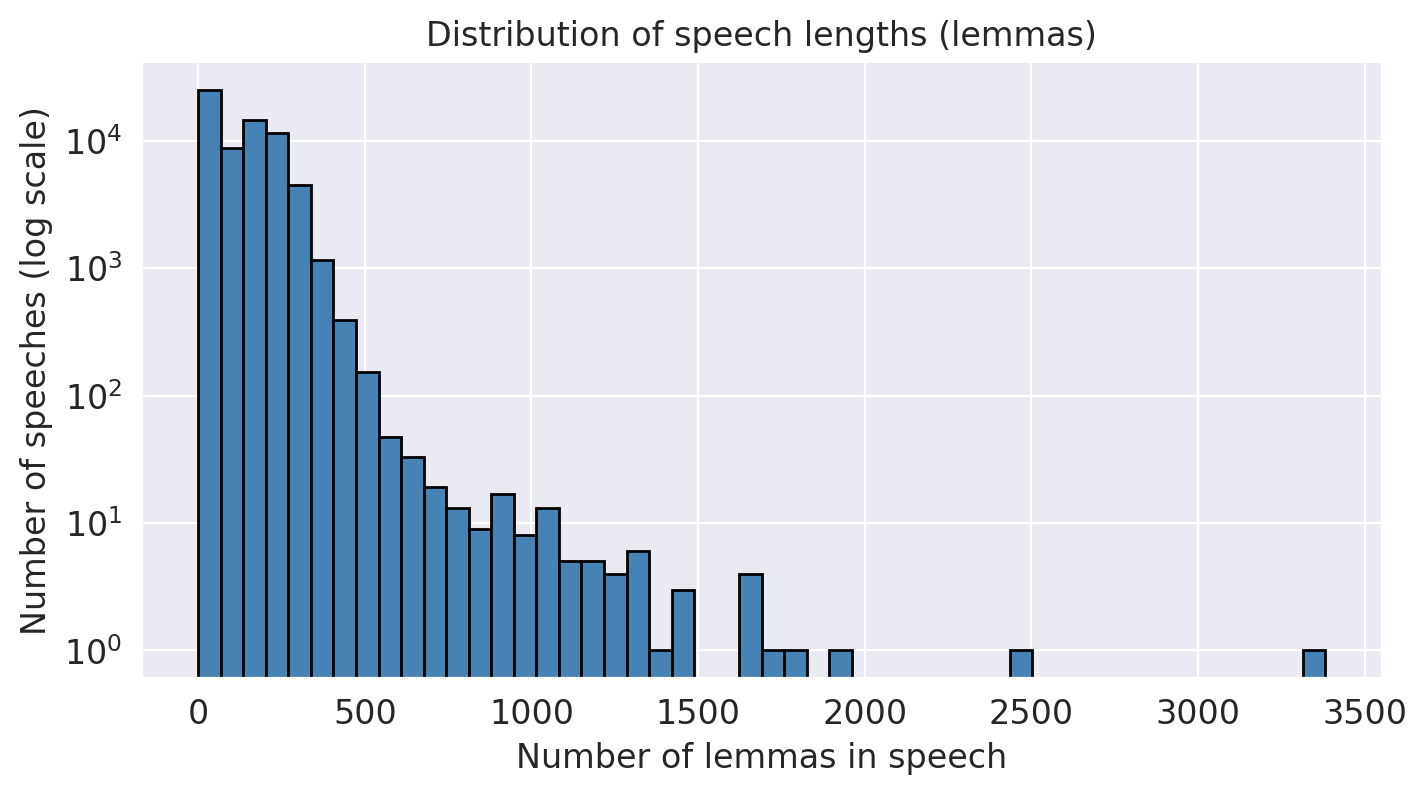


How many speeches are below the cutoff (50 lemmas)?
Speeches below 50 lemmas: 21767 (33.0%)
Excluding all speeches below a threshold of 50 lemmas would remove 33.0% of the corpus. 


In [21]:
print_speech_length_distribution(df["speech_length_lemmas"], df_length=len(df))
print_short_speech_stats(df["speech_length_lemmas"], short_cutoff=50)

The distribution shows a large number of very short speeches—likely to be procedural and formulaic, not useful for topic modeling.
Excluding all speeches below a threshold of 50 lemmas would remove 33.0% of the corpus.



# Based on the previous analysis, we adjust min_df and max_df, expand the custom stopword list, and set a cut-off at 50 lemmas for speech length.

In [24]:
min_lemmas = 50
df_long = df[df["speech_length_lemmas"] >= min_lemmas].copy()
print(f"\nTotal speeches after filtering: {len(df_long)} ({100 * len(df_long) / len(df):.1f}% of original corpus)")
print(f"Cutoff: Only speeches with at least {min_lemmas} lemmas included.")

custom_stopwords = [
    "präsident", "kollege", "kolleginn", "abgeordnete", "jahr", "danke",
    "deutschland", "land", "mensch", "menschen", "tag", "ende", "mal", "genau", "wichtig",
    "antrag", "thema", "herr", "frau", "bundesrepublik",
    "sagen", "brauchen", "stellen", "stehen", "wollen", "wissen", "machen", "reden"
]

# Re-run vocabulary statistics
X_tf, vocab, count_vect = get_count_matrix(df_long, text_col, min_df=5, max_df=0.99, stop_words=custom_stopwords)
freq_df = analyze_term_frequencies(X_tf, vocab)


Total speeches after filtering: 44197 (67.0% of original corpus)
Cutoff: Only speeches with at least 50 lemmas included.
Top 30 terms by document frequency:
           term  doc_freq  rel_doc_freq
        deutsch     16308          0.37
        letzter     15932          0.36
          frage     15864          0.36
          sehen     14551          0.33
           klar     14128          0.32
         finden     13855          0.31
          geben     13343          0.30
           euro     13091          0.30
         lassen     13050          0.30
bundesregierung     12498          0.28
        einfach     12123          0.27
         nehmen     11948          0.27
        bringen     11540          0.26
       deutlich     11494          0.26
       schaffen     11383          0.26
        bleiben     11313          0.26
         zeigen     11231          0.25
        nämlich     11189          0.25
     eigentlich     11101          0.25
         führen     11070          0.25
  

Now we are ready to run the first topic modeling iteration, using LDA and NMF

In [28]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
import time

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, random_state=42)
nmf = NMF(n_components=n_topics, max_iter=200, random_state=42)



In [29]:
start_time = time.time()
lda.fit(X_tf)
elapsed_time = time.time() - start_time
print(f"LDA training completed in {elapsed_time:.2f} seconds.")

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


LDA training completed in 293.67 seconds.


In [30]:
start_time = time.time()
nmf.fit(X_tf)
elapsed_time = time.time() - start_time
print(f"NMF training completed in {elapsed_time:.2f} seconds.")


,n_components,10
,init,None
,solver,'cd'
,beta_loss,'frobenius'
,tol,0.0001
,max_iter,200
,random_state,42
,alpha_W,0.0
,alpha_H,'same'
,l1_ratio,0.0
,verbose,0


NMF training completed in 16.34 seconds.


In [31]:
def list_topics(model, feature_names, n_words=15):
    topics = []
    for topic_idx, comp in enumerate(model.components_):
        topic_words = [feature_names[i] for i in comp.argsort()[:-n_words-1:-1]]
        topics.append(topic_words)
        print(f"Topic {topic_idx+1:02d}: " + ", ".join(topic_words))
    return topics



In [32]:
print("=== LDA: Top 10 terms per topic ===")
lda_topics = list_topics(lda, vocab, n_words=10)

print("\n=== NMF: Top 10 terms per topic ===")
nmf_topics = list_topics(nmf, vocab, n_words=10)


=== LDA: Top 10 terms per topic ===
Topic 01: euro, milliarde, geld, haushalt, prozent, million, deutsch, bürger, regierung, letzter
Topic 02: union, afd, deutsch, europäisch, europa, migration, frage, politik, problem, sprechen
Topic 03: kind, familie, pandemie, bund, bildung, gemeinsam, schule, letzter, maßnahme, frage
Topic 04: europäisch, europa, deutsch, bundesregierung, international, gemeinsam, russland, eu, staat, bundeswehr
Topic 05: euro, prozent, arbeit, sozial, arbeiten, hoch, einkommen, rente, million, arbeitnehmer
Topic 06: afd, deutsch, demokratie, politisch, partei, bundestag, demokratisch, leben, frage, freiheit
Topic 07: unternehmen, wirtschaft, prozent, zukunft, letzter, erneuerbar, bringen, bundesregierung, schaffen, co
Topic 08: kommune, wohnung, sozial, bauen, euro, million, ländlich, stadt, prozent, mieter
Topic 09: leben, gesetz, gewalt, fall, bundeswehr, soldat, betroffen, sicherheit, patient, polizei
Topic 10: gesetz, gesetzentwurf, frage, regelung, verfahren,

### Topic Modeling: Model Selection and Topic Interpretation

In the following steps, we systematically explore the influence of the number of topics (K) on the interpretability and quality of topic models using both Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF).  
For each selected value of K, we inspect the top keywords for every topic and assess their semantic coherence.  
This approach ensures transparency and enables us to select the most meaningful models for further analysis and interpretation.


### Topic Model Evaluation and Interpretation

For each model and topic count, the following aspects will be observed:
- **Semantic coherence:** Do the top keywords form a meaningful group?
- **Overlap and generality:** Does each topic describe a specific, distinguishable aspect of the corpus or are there overlapping/general topics?
- **Interpretability:** Can a clear label/title be assigned to each topic based on its keywords?

Based on these analyses, we will select the most suitable models (for both LDA and NMF) for further inspection, topic labeling, and detailed document analysis.

**Note on Convergence Warnings:**

During model fitting, `ConvergenceWarning` messages were issued for NMF, indicating that the maximum number of iterations was reached before strict mathematical convergence. 
For practical topic modeling on large, diverse corpora such as parliamentary transcripts, this is a common occurrence and does not necessarily affect the usefulness or interpretability of the topics. If higher mathematical precision were required, increasing the `max_iter` parameter could further improve convergence.

The LDA log perplexity values are negative and large, as expected for high-dimensional document-term matrices. Absolute values are not directly interpretable but may help in comparing models across topic numbers.

For all further interpretation, we rely primarily on the coherence and distinctiveness of the topics as revealed by their top keywords and associated documents.

In [56]:
# Define list of topic numbers to try
topic_range = [5, 10, 15, 20]
lda_models = {}
nmf_models = {}

def print_top_words(model, feature_names, n_top_words=10):
    result = []
    for topic_idx, topic in enumerate(model.components_):
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        print(f"Topic {topic_idx+1:02d}: " + ", ".join(top_words))
        result.append(top_words)
    return result

for n_topics in topic_range:
    print(f"\n========== RESULTS: {n_topics} Topics ==========")
    # LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=1, max_iter=20)
    lda.fit(X_tf)
    lda_models[n_topics] = lda
    print("--- LDA ---")
    lda_topwords = print_top_words(lda, vocab)
    print(f"\n[LDA] Log Perplexity (higher is better): {lda.score(X_tf):.2f}")

    # NMF
    nmf = NMF(n_components=n_topics, random_state=1, max_iter=200)
    nmf.fit(X_tf)
    nmf_models[n_topics] = nmf
    print("\n--- NMF ---")
    nmf_topwords = print_top_words(nmf, vocab)
    print(f"\n[NMF] Reconstruction error (lower is better): {nmf.reconstruction_err_:.2f}")


========== RESULTS: 5 Topics ==========
--- LDA ---
Topic 01: deutsch, afd, europa, europäisch, politisch, demokratie, staat, leben, klar, frage
Topic 02: kind, bundeswehr, soldat, gemeinsam, einsatz, sicherheit, euro, deutsch, familie, million
Topic 03: euro, milliarde, prozent, geld, sozial, million, unternehmen, letzter, haushalt, hoch
Topic 04: bereich, zukunft, million, sehen, prozent, deutsch, bundesregierung, schaffen, forschung, digital
Topic 05: gesetz, europäisch, frage, gesetzentwurf, unternehmen, klar, eu, deutsch, union, letzter

[LDA] Log Perplexity (higher is better): -65825890.70

--- NMF ---
Topic 01: frage, gesetz, letzter, finden, klar, unternehmen, sehen, schaffen, einfach, prozent
Topic 02: euro, milliarde, million, haushalt, prozent, geld, bund, zusätzlich, kosten, nächster
Topic 03: europäisch, europa, union, eu, gemeinsam, klar, staat, stark, national, russland
Topic 04: deutsch, afd, bundestag, bundesregierung, politisch, soldat, bundeswehr, staat, demokratie,

/root/env/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(



--- NMF ---
Topic 01: frage, finden, letzter, sehen, gemeinsam, klar, stelle, problem, geben, einfach
Topic 02: euro, milliarde, million, haushalt, geld, bund, zusätzlich, kosten, nächster, verfügung
Topic 03: europäisch, europa, union, eu, gemeinsam, national, staat, kommission, klar, mitgliedstaat
Topic 04: deutsch, bundestag, bundesregierung, interesse, französisch, welt, regierung, politik, sprache, sprechen
Topic 05: kind, familie, eltern, leben, bildung, schule, gesellschaft, jung, jugendlich, sozial
Topic 06: gesetz, gesetzentwurf, regelung, verfahren, schaffen, fall, klar, möglichkeit, gelten, änderung
Topic 07: unternehmen, bundesregierung, wirtschaft, bürger, sozial, zukunft, schaffen, krise, wirtschaftlich, sorgen
Topic 08: prozent, liegen, hoch, zahl, problem, letzter, steigen, deutlich, linker, eu
Topic 09: soldat, bundeswehr, einsatz, sicherheit, bundesregierung, international, soldatinn, russland, nato, krieg
Topic 10: afd, demokratie, partei, politisch, bürger, fraktio

/root/env/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(



--- NMF ---
Topic 01: finden, problem, letzter, einfach, sehen, eigentlich, stelle, geben, nämlich, nehmen
Topic 02: euro, milliarde, million, geld, haushalt, zusätzlich, bund, kosten, höhe, verfügung
Topic 03: europäisch, union, gemeinsam, national, mitgliedstaat, kommission, ebene, parlament, staat, rat
Topic 04: deutsch, bundestag, französisch, interesse, welt, sprache, welle, geschichte, international, frankreich
Topic 05: kind, familie, eltern, leben, schule, jugendlich, bildung, kita, jung, kindern
Topic 06: gesetz, gesetzentwurf, regelung, schaffen, verfahren, klar, schritt, änderung, fall, gelten
Topic 07: unternehmen, wirtschaft, krise, arbeitsplatz, staat, wirtschaftlich, investition, schaffen, bürokratie, betrieb
Topic 08: prozent, liegen, zahl, hoch, steigen, ziel, deutlich, erreichen, zahlen, co
Topic 09: soldat, bundeswehr, einsatz, soldatinn, sicherheit, mandat, mali, afghanistan, mission, nato
Topic 10: frage, eigentlich, antwort, debatte, beantworten, entscheidung, fr

#### Final Topic Model: LDA with 15 Topics

After comparing models with different numbers of topics, we selected LDA with 15 topics as the final model for our analysis. This solution offers a good trade-off between specificity and thematic coherence, as the main political subjects are well-separated and major German policy areas are reflected by distinct topics.
Below, we assign descriptive labels to each topic based on their top keywords, then present example speeches per topic and critically assess the model quality.

In [ ]:
chosen_k = 15

# Extract top words per topic for LDA
lda = lda_models[chosen_k]
lda_topics = []
for topic_idx, topic in enumerate(lda.components_):
    lda_topics.append([vocab[i] for i in topic.argsort()[:-11:-1]]) # top 10

# Human labels
lda_labels = [
    "AFD & Demokratie",
    "Familie & Soziales",
    "Geld & Bürger",
    "ÖPNV & Verkehr",
    "erneuerbare energien",
    "EU Klimapolitik",
    "Wirtschaft & Außenpolitik",
    "Bildung",
    "Migration & Integration",
    "Pandemie & Gesundheit",
    "Digitalisierung & Pflege",
    "Israel als EU-Mitglied",
    "Landwirtschaftsbetriebe",
    "Gesetzesentwürfe",
    "Ukrainekrieg und innere Sicherheit"
]

# Build data frame for reporting in notebook
topic_df = pd.DataFrame({
    "Topic #": [f"Topic {i+1}" for i in range(chosen_k)],
    "Keywords": [", ".join(words) for words in lda_topics],
    "Assigned Label": lda_labels
})
display(topic_df)

,Topic #,Keywords,Assigned Label
0,Topic 1,"afd, demokratie, leben, deutsch, politisch, ge...",AFD & Demokratie
1,Topic 2,"euro, kind, milliarde, haushalt, million, geld...",Familie & Soziales
2,Topic 3,"euro, prozent, milliarde, sozial, geld, hoch, ...",Geld & Bürger
3,Topic 4,"bahn, auto, mobilität, straße, infrastruktur, ...",ÖPNV & Verkehr
4,Topic 5,"erneuerbar, energie, strom, gas, unternehmen, ...",erneuerbare energien
5,Topic 6,"klimaschutz, co, eu, bundesregierung, ziel, gr...",EU Klimapolitik
6,Topic 7,"unternehmen, wirtschaft, deutsch, zukunft, ber...",Wirtschaft & Außenpolitik
7,Topic 8,"bildung, bundestag, bund, bafög, frage, gemein...",Bildung
8,Topic 9,"arbeit, migration, arbeiten, flüchtling, besch...",Migration & Integration
9,Topic 10,"bürger, maßnahme, pandemie, bundesregierung, f...",Pandemie & Gesundheit


In [61]:
# Show the top 3 speeches for each topic according to LDA topic distribution
topic_dist = lda.transform(X_tf)
for topic_idx in range(chosen_k):
    print(f"\n--- Example Speeches for {lda_labels[topic_idx]} (Topic {topic_idx+1}) ---")
    # Get top 3 speeches for this topic (highest topic proportion)
    top_doc_idx = topic_dist[:, topic_idx].argsort()[-3:][::-1]
    for idx in top_doc_idx:
        doc_id = df_long["id"].iloc[idx]
        snippet = df_long["speech_content_lemmatized"].iloc[idx][:250]  # show first 250 chars
        print(f"Doc ID: {doc_id}, Score: {topic_dist[idx, topic_idx]:.2f}")
        print(snippet)
        print("---")


--- Example Speeches for AFD & Demokratie (Topic 1) ---
Doc ID: 1102599, Score: 1.00
versuchen kräftig Stimmung beweisen Respekt heutig tag vorkommnisse letzter wochenender essen Berlin bedürf Aufarbeitung demokratisch Versammlungsrecht nutzen islamistisch Idee vertreten grundsätzlich verstehen ahnden froh innenministerin Nancy Faese
---
Doc ID: 1066455, Score: 0.99
alt leben Deutschland verlassen hanau jung Mensch ermorden Mensch Mensch gedicht Schriebe Mensch heirat Leben Schmerz Leid hinterblieben nachempfind Schmerz hinterblieben Zimmer Opfer unberührt gelassen bettwäsch Abgezog wichtig gemeinsam gedenk Ansc
---
Doc ID: 1092113, Score: 0.99
Holocaustüberlebende Primo Levi gesproch Pflicht Zeugnis ablegen geschehen Weise Zeugnis ablegen nämlich Gott ns konzentrationslagern Ort extremsten gottesferne zeug Jehovas ernst bibelforsch nennen Reich inhaftieren ermorden zeugen Jehovas Jude inte
---

--- Example Speeches for Familie & Soziales (Topic 2) ---
Doc ID: 1032977, Score: 1.00
Pro

### Visualization
Now that we have made a structured comparison of both models, and evaluated a suitable number of topics we can use, it's time to create a visualization in the form of a word cloud. This way, the overview of the relevant topics can be easily presented.

In [34]:
from wordcloud import WordCloud

def plot_wordclouds(model, feature_names, topics=None, words_per_topic=20, cols=3, width=800, height=600):
    topics = topics or range(model.components_.shape[0])
    plt.figure(figsize=(width/100, height/100 * ((len(topics)//cols)+1)))
    for idx, topic_idx in enumerate(topics):
        plt.subplot((len(topics)-1)//cols + 1, cols, idx+1)
        topic = model.components_[topic_idx]
        freqs = {feature_names[i]: topic[i] for i in topic.argsort()[-words_per_topic:]}
        wc = WordCloud(width=width, height=height, background_color='white', colormap='tab10')
        wc.generate_from_frequencies(freqs)
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f"Topic {topic_idx+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()



LDA topics as wordclouds


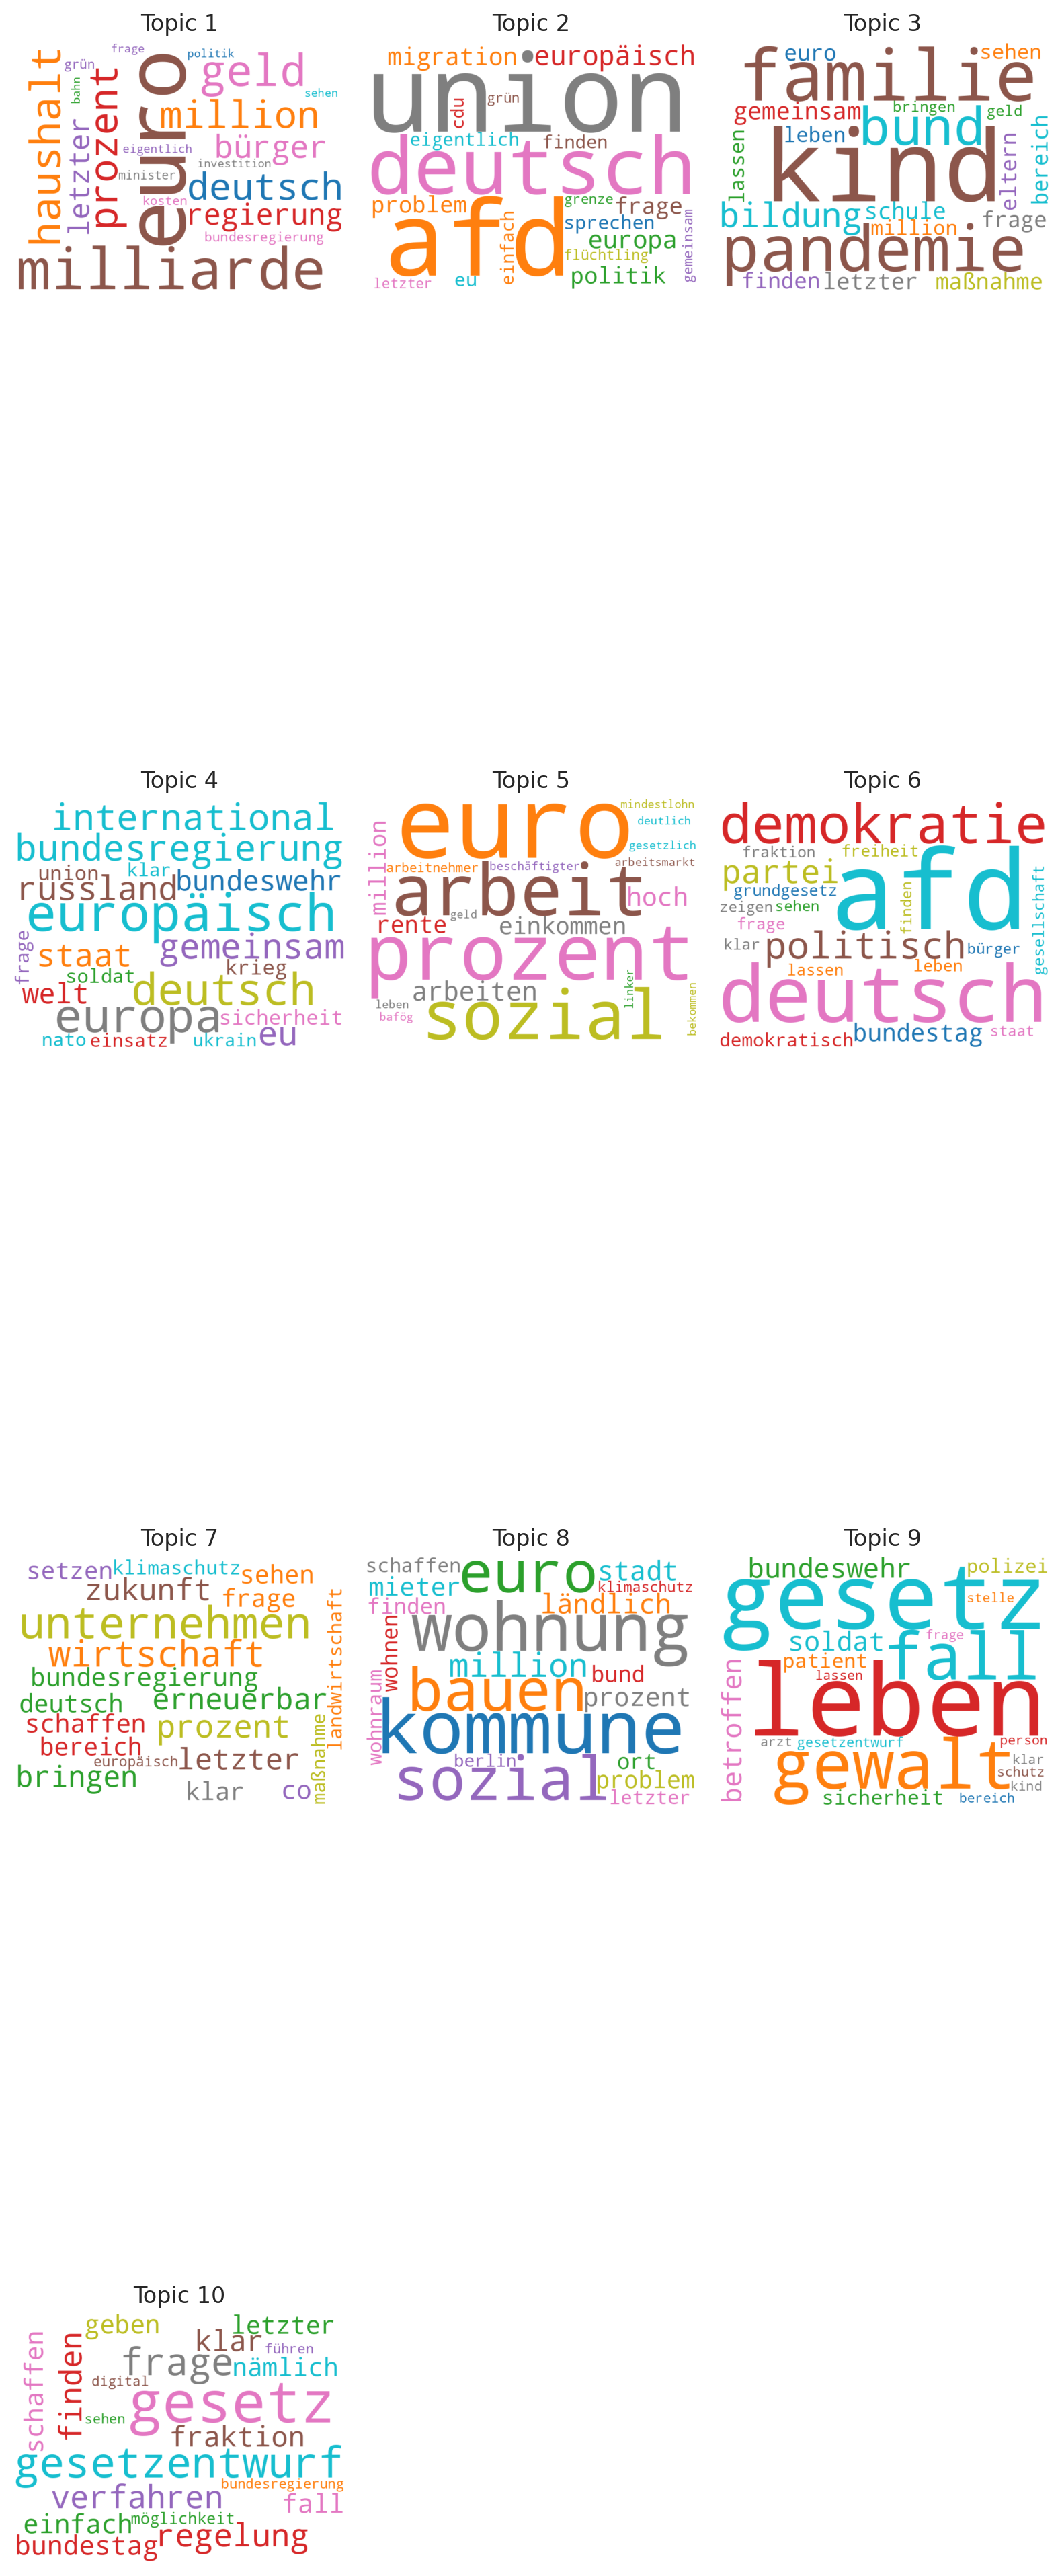

NMF topics as wordclouds


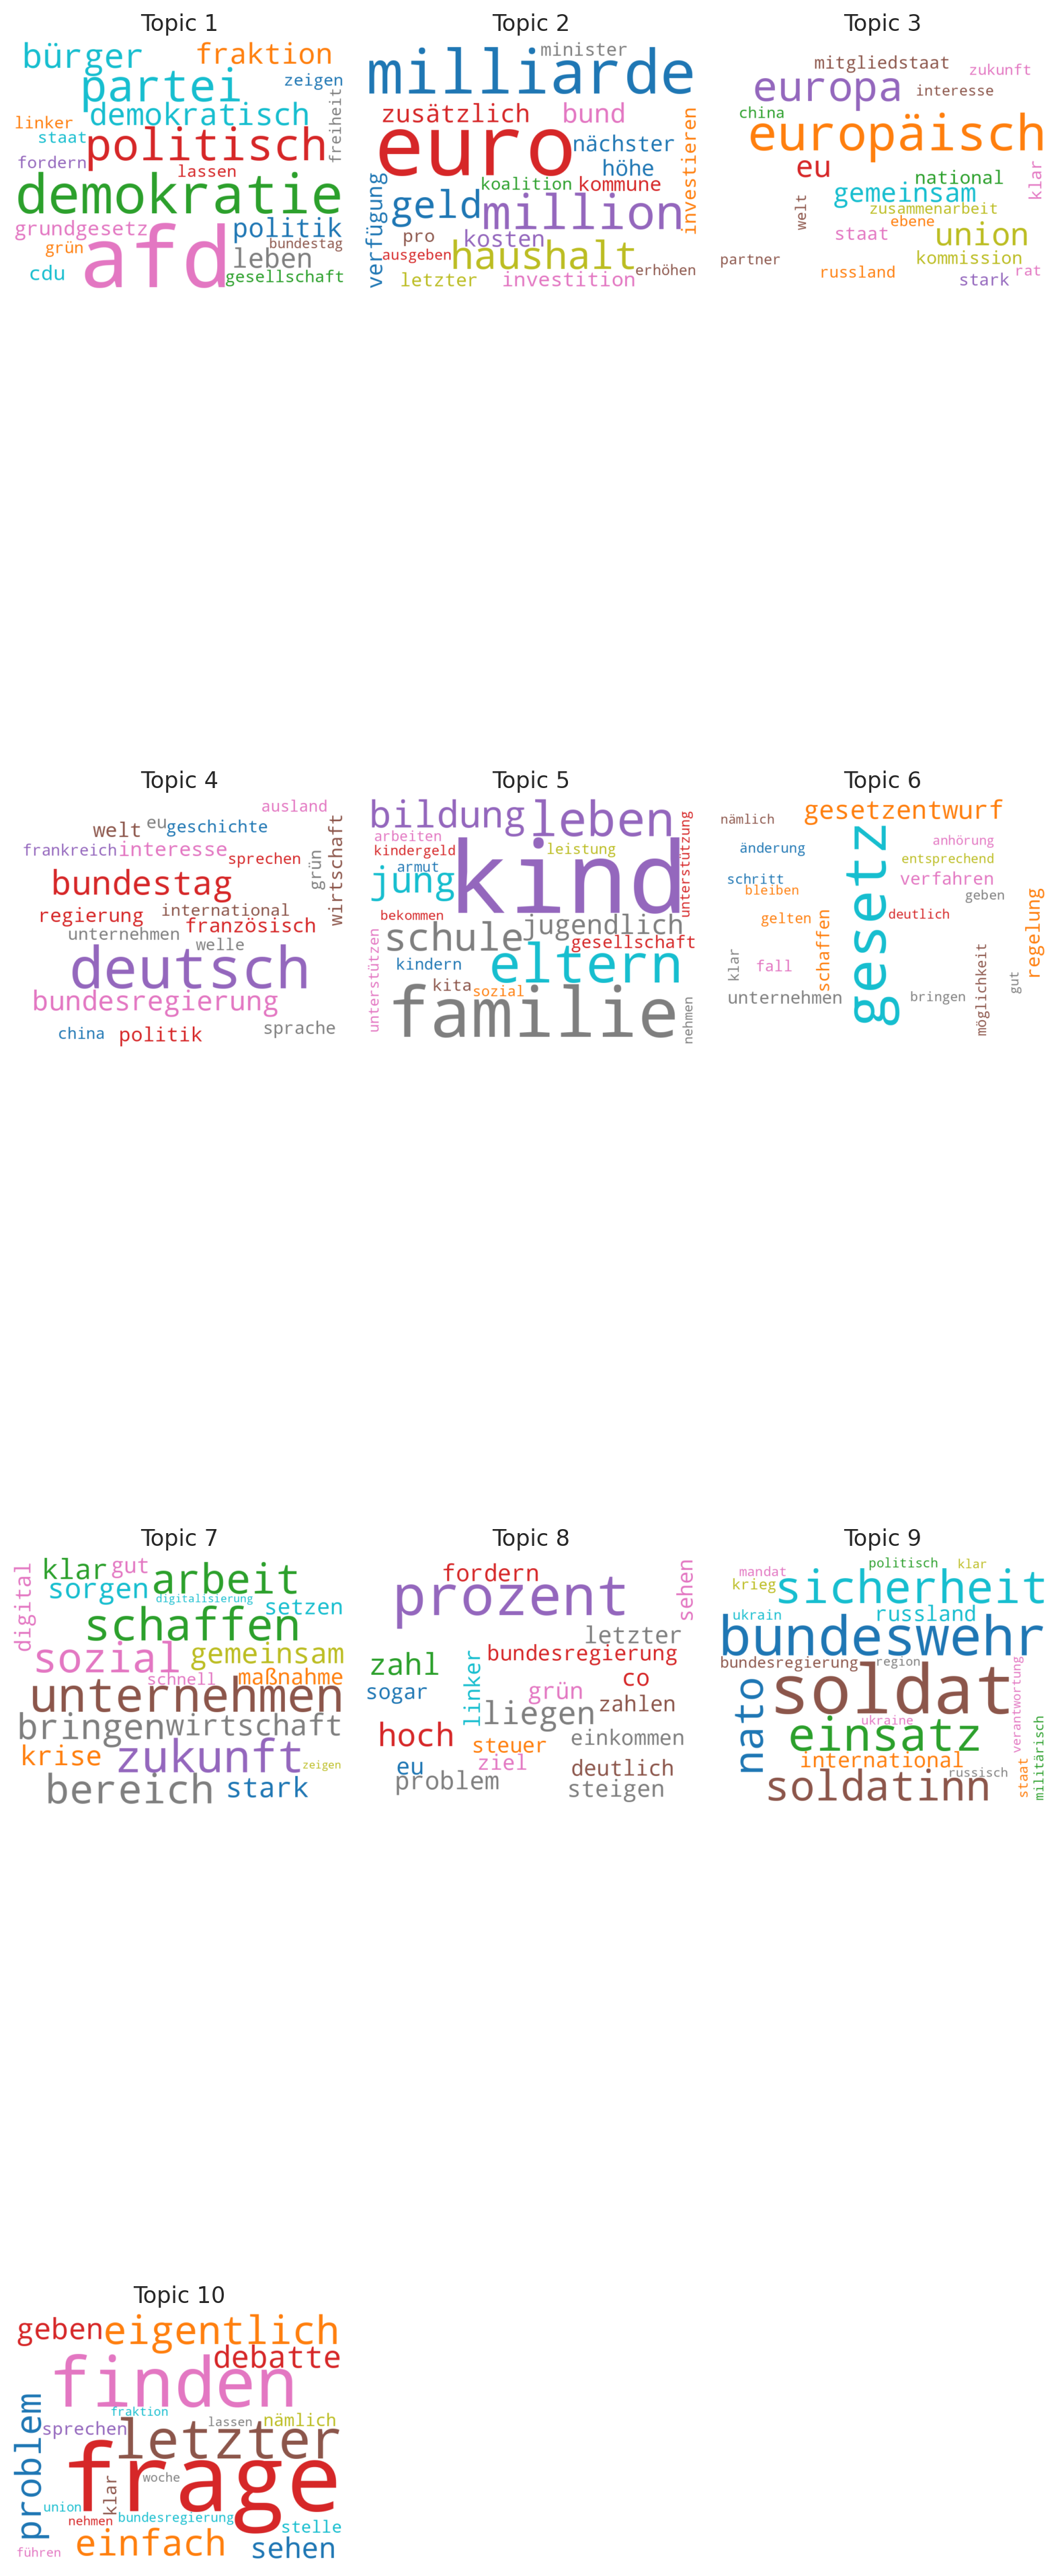

In [35]:
print("LDA topics as wordclouds")
plot_wordclouds(lda, vocab, topics=range(lda.n_components))

print("NMF topics as wordclouds")
plot_wordclouds(nmf, vocab, topics=range(nmf.n_components))

## Summary and evaluation
### Model Quality and Critical Reflection

#### Semantic Coherence

- **LDA:**  
  In several topics, top keywords cohere around well-known parliamentary subject areas—such as "budget", "climate", "migration", and "outer policy". LDA’s probabilistic foundation often leads to topics reflecting thematic clusters apparent in political discourse.
- **NMF:**  
  NMF also produces semantically coherent topics, sometimes with even more sharply defined boundaries due to its non-negativity constraint, e.g., topics like "family", "democracy", or "military" emerge distinctly. However, the parts-based nature can sometimes fragment themes excessively if K is set too high.

#### Topic Distinctiveness & Overlap

- **LDA:**  
  While most topics are distinct, a few (in both 10-topic and 15-topic models) show some overlap, e.g., mentions of "EU" and "Europa" appear in several topics, indicating either general themes or insufficiently specific preprocessing. Overly frequent/multifaceted terms sometimes cause topic leakage.
- **NMF:**  
  Compared to LDA, NMF tends to split large, general themes into several finer topics, sometimes resulting in more interpretable subtopics (e.g., "family" distinct from "children"). Yet, occasionally, certain topics are too narrow or reflect word frequency artifacts.

#### Practical aspects
- **LDA:**  
  LDA converged without warnings. Its log-perplexity values (more negative is better) vary with K but are mostly for relative comparison, lacking an absolute interpretatHowever, as can be seen in the initial training, it uses significantly more computational power, resulting in a slower training compared to NMF.
- **NMF:**  
  NMF produced convergence warnings at default iteration limits. This is expected in heterogeneous corpora and does not generally invalidate qualitative topic analysis, though further increasing `max_iter` could yield improved fits. NMF is often faster per iteration but may require more iterations.



# Future works
After trying out these two traditional approaches for topic modeling, now follows an experiment for a different, transformer-based method. See the next notebook: [BERTopic](TopicModeling_BERTopic.ipynb)